# NNDL miniproj3 Conditional GAN
* sajjad pakdaman [810195517]
* fatemeh haghighi [810195385]

## setup
import necessary libs

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Concatenate
import random
from keras.utils import to_categorical

Using TensorFlow backend.


## Load and Visualize Dataset

In [15]:
(f_tra, l_tra), (f_tes, l_tes) = tf.keras.datasets.cifar10.load_data()
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [17]:
F = np.concatenate([f_tra, f_tes], axis=0)
# F = f_tes
F.shape

(60000, 32, 32, 3)

In [18]:
L = np.concatenate([l_tra, l_tes], axis=0)
# L = l_tes
L.shape

(60000, 1)

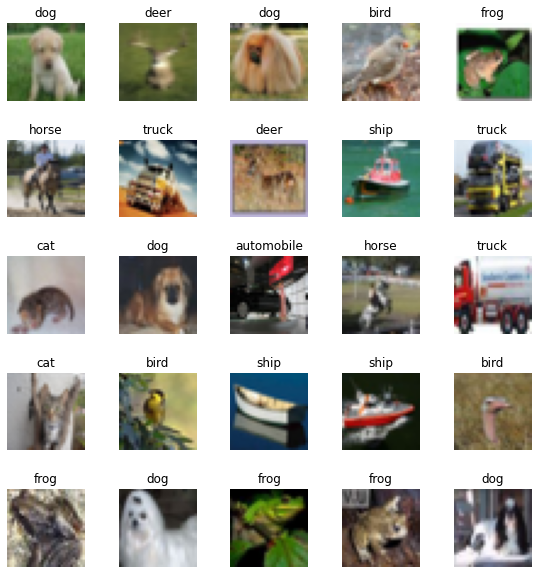

In [19]:
fig, axs = plt.subplots(5,5, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(25):
    index = random.randint(0, len(F))
    image = F[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(class_names[L[index][0]])

## preprocessing

In [20]:
F = np.float32(F)
F = (F / 255 - 0.5) * 2
F = np.clip(F, -1, 1)
# L = L.astype('float32')

In [21]:
(img_height, img_width, num_channels) = F[0].shape
condition_shape = L[0].shape

## Discriminator
make discriminator using CNN network

In [22]:
l      = Input(shape=(10,), name='condition') #(10, )
i      = Input(shape=(img_height, img_width, num_channels), name='discriminator_input') #(32, 32, 3)


d      = Conv2D(filters=32, kernel_size=5, strides=2, padding='same')(i) #(16, 16, 32)
d      = BatchNormalization()(d)
d      = layers.LeakyReLU()(d)

d      = Conv2D(filters=128, kernel_size=5, strides=2, padding='same')(d) #(8, 8, 128)
d      = BatchNormalization()(d)
d      = layers.LeakyReLU()(d)

d      = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(d) #(4, 4, 512)
d      = BatchNormalization()(d)
d      = layers.LeakyReLU()(d)

d      = Conv2D(filters=1024, kernel_size=2, strides=4, padding='same')(d) #(1, 1, 1024)
d      = BatchNormalization()(d)
d      = layers.LeakyReLU()(d)

d      = Flatten()(d) #(1024, )

d      = Concatenate()([d, l]) #(1034, )

d      = Dense(32, activation='relu')(d) #(32, )
d_o      = Dense(1 , activation='sigmoid')(d) #(1, )

discriminator = keras.Model([i, l], d_o, name="discriminator")
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
discriminator_input (InputLayer [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 32)   2432        discriminator_input[0][0]        
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 16, 16, 32)   128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 16, 16, 32)   0           batch_normalization_8[0][0]      
______________________________________________________________________________________

## generator
make generator

In [23]:
z_dim = 128
z        = Input(shape=(z_dim, ), name='z_input') #(z_dim, )

g        = Concatenate()([z, l]) #(138,)
g        = Dense(1024)(g)
g        = BatchNormalization()(g)
g        = layers.LeakyReLU()(g)
g        = Reshape(target_shape=(1,1,1024))(g) #(1,1,1024)

g        = layers.Conv2DTranspose(512, 2, strides=4, padding='same')(g) #(4, 4, 512)
g        = layers.LeakyReLU()(g)
g        = BatchNormalization()(g)

g        = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(g) #(8, 8, 128)
g        = layers.LeakyReLU()(g)
g        = BatchNormalization()(g)

g        = layers.Conv2DTranspose(32, 5, strides=2, padding='same')(g) #(16, 16, 32)
g        = layers.LeakyReLU()(g)
g        = BatchNormalization()(g)

fake     = layers.Conv2DTranspose(3, 5, strides=2, padding='same', activation='tanh')(g) #(32, 32, 3)

generator = keras.Model([z, l], fake, name="generator")
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z_input (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
condition (InputLayer)          [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 138)          0           z_input[0][0]                    
                                                                 condition[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 1024)         142336      concatenate_3[0][0]      

test generator and discriminator to wark fine

## adversial

In [24]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(z_dim,), name='z')
fake_img = generator([z, label])
validity = discriminator([fake_img, label])

cgan = keras.Model([z, label], validity, name='adversarial')
cgan.summary()

Model: "adversarial"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  [(None, 128)]        0                                            
__________________________________________________________________________________________________
label (InputLayer)              [(None, 10)]         0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    2941571     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            2833409     generator[1][0]        

## compile models

In [25]:
discriminator.compile(keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])
cgan.compile(keras.optimizers.Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])

craet random sample and pass it through network

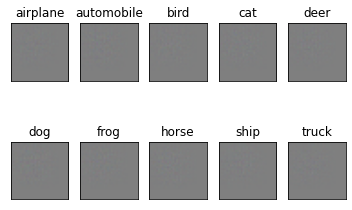

In [26]:
samples = 10
latent_dim = 128
z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)

x_fake = generator.predict([z, labels])
x_fake = np.clip(x_fake, -1, 1)
x_fake = (x_fake + 1) * 127
x_fake = np.round(x_fake).astype('uint8')

for k in range(samples):
    plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
    plt.imshow(x_fake[k])
    plt.title(class_names[k])

In [27]:
X_train = F
y_train = L

epoch = 1/10, d_loss=1.312, g_loss=0.154                                                                                                     


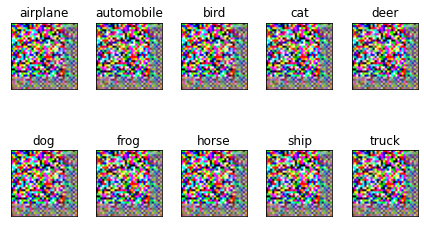

epoch = 2/10, d_loss=1.307, g_loss=0.156                                                                                                     


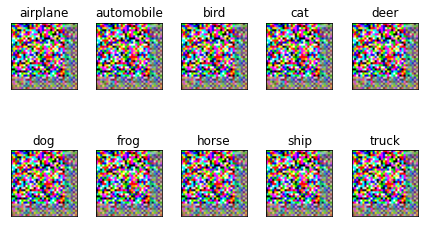

epoch = 3/10, d_loss=1.313, g_loss=0.154                                                                                                     


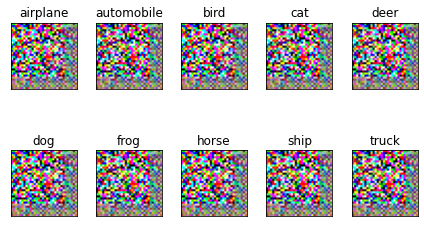

epoch = 4/10, d_loss=1.314, g_loss=0.155                                                                                                     


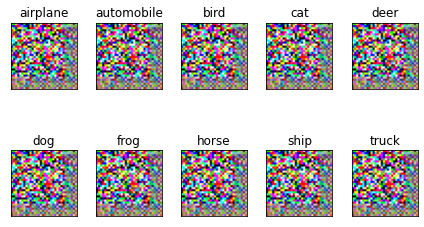

epoch = 5/10, d_loss=1.316, g_loss=0.154                                                                                                     


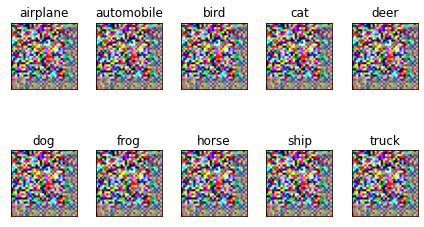

KeyboardInterrupt: ignored

In [30]:
epochs = 10
batch_size = 64
smooth = 0.1
latent_dim = 128

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = cgan.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 1 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.52494484]], dtype=float32)>

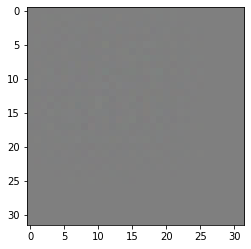

In [ ]:
noise     = np.random.normal(size=(1,z_dim)).astype('float32')
condition = np.random.randint(0, 10, 1).reshape(-1, 1).astype('float32')
condition = to_categorical(condition, num_classes=10)

fake_image_test = generator([noise, condition], training=False)
# fake_image_test
plt.imshow(fake_image_test[0])

decision = discriminator([fake_image_test, condition], training=False)
decision

generate seed for visualization

In [ ]:
noise_dim = z_dim
num_examples_to_generate = 10 * 10

noise_seed = np.random.normal(size=(num_examples_to_generate, noise_dim)).astype('float32')
condition_seed = []
for i in range(10):
    for j in range(10):
        condition_seed.append(j)

condition_seed = to_categorical(np.array(condition_seed).reshape(num_examples_to_generate, 1).astype('float32'), num_classes=10)

function to generate 10x10 image grid from seeds

In [ ]:
def generate_images(epoch, model=generator):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model([noise_seed, condition_seed], training=False)

  fig = plt.figure(figsize=(10,10))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 10, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  fig.suptitle(f'epoch: {epoch}', fontsize=20)
  plt.show()

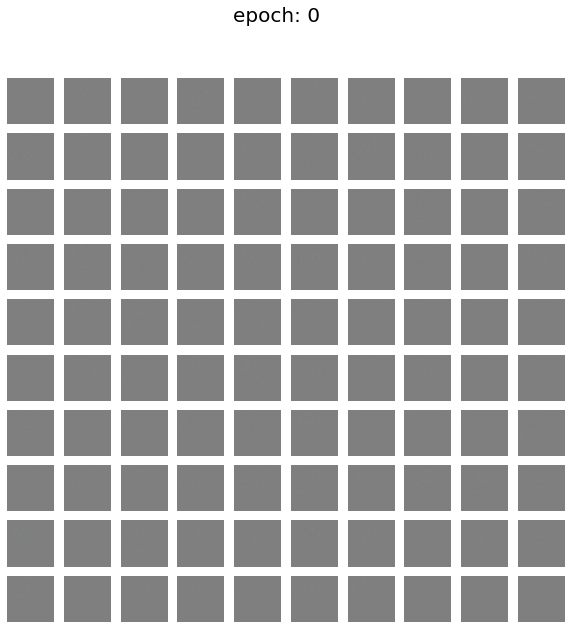

In [ ]:
generate_images(0)

## train step

In [ ]:
def train_step_discriminator(X_batch, Y_batch):
    discriminator.trainable = True
    real_labels = Y_batch
    batch_size = (Y_batch.shape)[0]

    real = np.ones((batch_size, 1)) * 0.99
    fake = np.zeros_like(real)

    # train on real images
    d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],y=real)
    
    # train on fake images
    z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
    random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
    X_fake = generator.predict_on_batch([z, random_labels])
    d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
        
    # Discriminator loss
    d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
    return d_loss_batch

def train_step_generator(X_batch, Y_batch):
    discriminator.trainable = False
    batch_size = X_batch.shape[0]
    real = np.ones((batch_size, 1)) * 0.99

    z = np.random.normal(loc=0, scale=1, size=(batch_size, z_dim))
    random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
    g_loss_batch = cgan.train_on_batch(x=[z, random_labels], y=real)
    return g_loss_batch[0]


def train_step_cgan(X_batch, Y_batch):
    d_loss = train_step_discriminator(X_batch, Y_batch)
    g_loss = train_step_generator(X_batch, Y_batch)
    return d_loss, g_loss

def train(FDS, LDS, epochs, num_batches_per_epoch, history=None):
    if history is None:
        history = {'gen_loss':[], 'disc_loss':[]}

    for epoch in range(epochs):
        count = 0
        print(f'epoch: {epoch+1}/{epochs}')
        # init progbar for each epoch
        progbar = keras.utils.Progbar(target=num_batches_per_epoch)

        for image_batch, condition_batch in zip(FDS, LDS):
            count += 1
            disc_loss, gen_loss = train_step_cgan(image_batch, condition_batch)
            # update brogbar
            progbar.update(count, [('dics_loss', disc_loss), ('gen_loss', gen_loss)])
            # record losses to history
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)

        if (epoch + 1) % 10 == 0:
            generate_images(epoch + 1)
    return history

## train the model

In [ ]:
BATCH_SIZE = 64
FDS = tf.data.Dataset.from_tensor_slices(F).batch(BATCH_SIZE)
LDS = tf.data.Dataset.from_tensor_slices(to_categorical(L, num_classes=10)).batch(BATCH_SIZE)
epochs = 150
history = {'gen_loss':[], 'disc_loss':[]}

epoch: 1/150
938/937 [==============================] - 86s 92ms/step - dics_loss: 0.9087 - gen_loss: 0.4019
epoch: 2/150
938/937 [==============================] - 83s 89ms/step - dics_loss: 0.9143 - gen_loss: 0.3964
epoch: 3/150
938/937 [==============================] - 82s 88ms/step - dics_loss: 0.9166 - gen_loss: 0.3944
epoch: 4/150
938/937 [==============================] - 81s 87ms/step - dics_loss: 0.9175 - gen_loss: 0.3933
epoch: 5/150
938/937 [==============================] - 81s 86ms/step - dics_loss: 0.9182 - gen_loss: 0.3928
epoch: 6/150
938/937 [==============================] - 82s 87ms/step - dics_loss: 0.9185 - gen_loss: 0.3924
epoch: 7/150
938/937 [==============================] - 81s 86ms/step - dics_loss: 0.9186 - gen_loss: 0.3923
epoch: 8/150
938/937 [==============================] - 81s 86ms/step - dics_loss: 0.9186 - gen_loss: 0.3921
epoch: 9/150
938/937 [==============================] - 80s 86ms/step - dics_loss: 0.9189 - gen_loss: 0.3921
epoch: 10/150
938/9

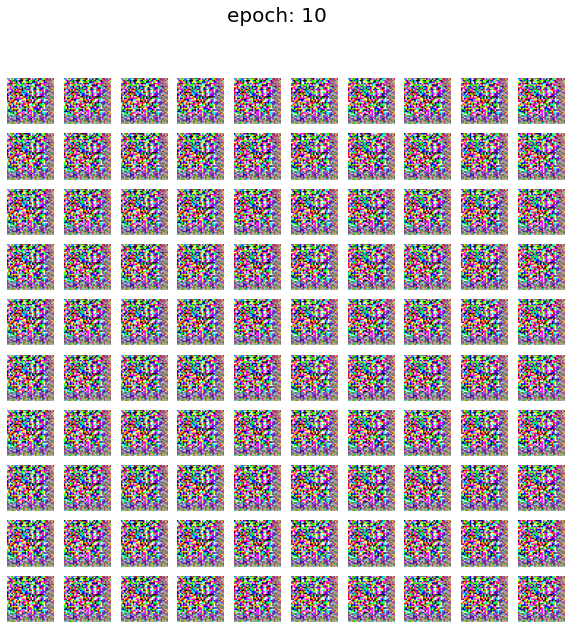

epoch: 11/150
938/937 [==============================] - 80s 86ms/step - dics_loss: 0.9192 - gen_loss: 0.3919
epoch: 12/150
938/937 [==============================] - 80s 86ms/step - dics_loss: 0.9193 - gen_loss: 0.3918
epoch: 13/150
938/937 [==============================] - 82s 87ms/step - dics_loss: 0.9193 - gen_loss: 0.3917
epoch: 14/150
938/937 [==============================] - 84s 90ms/step - dics_loss: 0.9194 - gen_loss: 0.3915
epoch: 15/150
938/937 [==============================] - 83s 88ms/step - dics_loss: 0.9194 - gen_loss: 0.3916
epoch: 16/150
938/937 [==============================] - 82s 88ms/step - dics_loss: 0.9194 - gen_loss: 0.3916
epoch: 17/150
938/937 [==============================] - 83s 88ms/step - dics_loss: 0.9195 - gen_loss: 0.3916
epoch: 18/150
938/937 [==============================] - 81s 86ms/step - dics_loss: 0.9195 - gen_loss: 0.3914
epoch: 19/150
938/937 [==============================] - 81s 86ms/step - dics_loss: 0.9197 - gen_loss: 0.3915
epoch: 20/

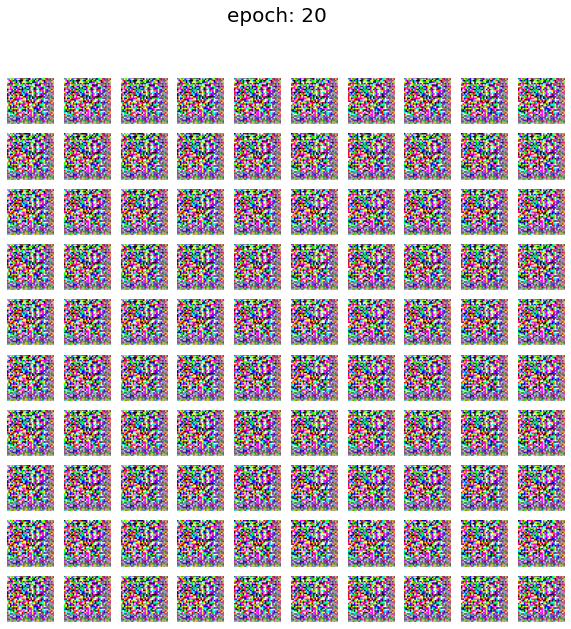

epoch: 21/150
938/937 [==============================] - 83s 88ms/step - dics_loss: 0.9196 - gen_loss: 0.3914
epoch: 22/150
834/937 [=========================>....] - ETA: 8s - dics_loss: 0.9196 - gen_loss: 0.3913

KeyboardInterrupt: ignored

In [ ]:
history = train(FDS, LDS, epochs, len(F)/BATCH_SIZE, history)

In [ ]:
x = np.linspace(0, epochs, len(history['gen_loss']))
plt.plot(x, history['gen_loss'], label='gen_loss')
plt.plot(x, history['disc_loss'], label='disc_loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('CGAN loss')
plt.legend()

(60000, 10)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# cross_entropy = tf.keras.losses.mse
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

# generator_optimizer = tf.keras.optimizers.SGD()
# discriminator_optimizer = tf.keras.optimizers.SGD()


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    # total_loss = tf.reduce_mean(total_loss, axis=0)
    # print(total_loss)
    return total_loss

def generator_loss(fake_output):
    return (cross_entropy(tf.ones_like(fake_output), fake_output))

create fix noise for visualization

In [ ]:
noise_dim = z_dim
num_examples_to_generate = 10 * 10

noise_seed = np.random.normal(size=(num_examples_to_generate, noise_dim)).astype('float32')
condition_seed = []
for i in range(10):
    for j in range(10):
        condition_seed.append(j/10)
condition_seed = np.array(condition_seed).reshape(num_examples_to_generate, 1).astype('float32')

In [ ]:
noise_seed.shape , condition_seed.shape

((100, 32), (100, 1))

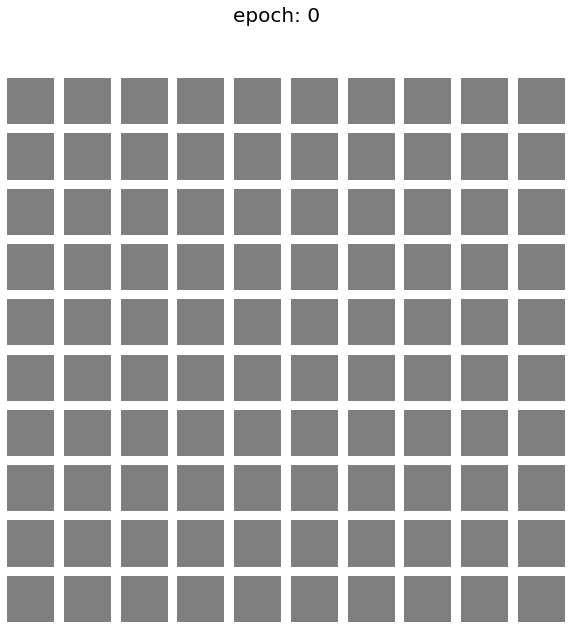

In [ ]:
generate_images(0)

Train step function, a pass on g

In [ ]:

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, conditions, BATCH_SIZE):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator([noise, conditions], training=True)

      real_output = discriminator([images, conditions], training=True)
      fake_output = discriminator([generated_images, conditions], training=True)

      gen_loss  = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

train loop

In [ ]:
def train(FDS, LDS, epochs, BATCH_SIZE, num_batches_per_epoch):
  history = {'gen_loss':[], 'disc_loss':[]}
  metrics = ['gen_loss', 'disc_loss']
  for epoch in range(epochs):
    print(f'epoch: {epoch+1}/{epochs}')
    progbar = keras.utils.Progbar(target=num_batches_per_epoch)

    count = 0
    for image_batch, condition_batch in zip(FDS, LDS):
      count += 1
      gen_loss, disc_loss = train_step(image_batch, condition_batch, BATCH_SIZE)
      progbar.update(count, [('gen_loss', gen_loss), ('dics_loss', disc_loss)])
      history['gen_loss'].append(gen_loss)
      history['disc_loss'].append(disc_loss)

    if (epoch + 1) % 10 == 0:
      generate_images(epoch + 1)
  return history

In [ ]:
BATCH_SIZE = 1000
FDS = tf.data.Dataset.from_tensor_slices(F).batch(BATCH_SIZE)
LDS = tf.data.Dataset.from_tensor_slices(L).batch(BATCH_SIZE)
epochs = 200

In [ ]:
history = train(FDS, LDS, epochs, BATCH_SIZE, len(F)/BATCH_SIZE)

## plot loss


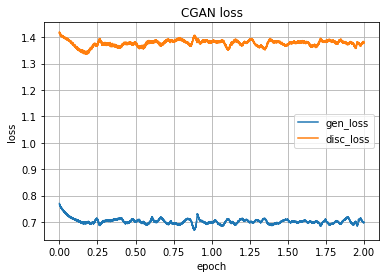

In [ ]:
x = np.linspace(0, 2, len(history['gen_loss']))
plt.plot(x, history['gen_loss'], label='gen_loss')
plt.plot(x, history['disc_loss'], label='disc_loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('CGAN loss')
plt.legend()

In [ ]:
class CGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(CGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(CGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        if isinstance(data, tuple):
            real_images = data[0]
            conditions  = data[1]
        else:
            real_images = data

        # train discriminator
        self.generator.trainable = False
        self.discriminator.trinable = True    

        # Sample random points in the latent space
        batch_size = (real_images).shape[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator([random_latent_vectors, conditions])

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Combined conditions
        combined_conditions = tf.concat([conditions, conditions], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.01 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_conditions])
            d_loss = tf.reduce_mean(self.loss_fn(labels, predictions))
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # train discriminator
        self.generator.trainable = True
        self.discriminator.trinable = False

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(2*batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((2*batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator([self.generator([random_latent_vectors, combined_conditions]), combined_conditions])
            g_loss = tf.reduce_mean(self.loss_fn(misleading_labels, predictions))
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [ ]:
cgan = CGAN(discriminator=discriminator, generator=generator, latent_dim=z_dim)
cgan.compile(
    d_optimizer=keras.optimizers.Adam(),
    g_optimizer=keras.optimizers.Adam(),
    loss_fn=keras.losses.MSE,
)

In [ ]:
history = cgan.fit(x=F, y=L, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.4449 - g_loss: 0.1407
Epoch 2/10
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.5050 - g_loss: 0.0000e+00
Epoch 3/10
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.5050 - g_loss: 0.0000e+00
Epoch 4/10
1875/1875 [==============================] - 37s 20ms/step - d_loss: 0.5050 - g_loss: 0.0000e+00
Epoch 5/10
1419/1875 [=====================>........] - ETA: 8s - d_loss: 0.5050 - g_loss: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
fake = generator([np.random.normal(size=(1, z_dim)), L[0:1]])
discriminator([fake, L[0:1]])